# Q1 (bad_xml)

In [1]:
import gzip, sys, os, re
from pyspark import SparkContext

import xml.etree.ElementTree as ET

def localpath(path):
    return str(os.path.abspath(os.path.curdir)) + path

def startsWithRow(line):
    return len( re.compile(u'^<row ').findall(line.strip()) ) > 0

def applyParser(line):
    try:
        root = ET.fromstring(re.compile(u'(^<row(.*?)\/>)').findall(line.strip())[0][0].encode('utf-8').strip())
        
        return root
    except:
        return None

In [7]:
my_input_dir = r'\spark-stats-data\allPosts\part-0*'

lines_1 = sc.textFile(localpath(my_input_dir)).map(startsWithRow).filter(lambda x: x is True).count()
lines_2 = sc.textFile(localpath(my_input_dir)).map(applyParser).filter(lambda x: x is not None).count()
lines_3 = lines_1-lines_2

print("lines with posts:\t {0}".format(lines_1) )
print("readable lines:\t\t {0}".format(lines_2) )
print("unreadable posts:\t {0}".format(lines_3) )

lines with posts:	 109522
readable lines:		 108721
unreadable posts:	 801


# Q2 (upvote_percentage)

In [8]:
class Vote_El(object): #I get a pickle error
    def __init__(self, PostId, Up, Down, Fav):
        self.PostId = PostId
        self.Up = Up
        self.Down = Down
        self.Fav = Fav
    
def Parse_Vote(line):
    
    root = applyParser(line)
    
    if root is not None:
        
        try:
            PostId = int(root.get('PostId'))
            Up, Down, Fav = 0, 0, 0
        
            var = int(root.get('VoteTypeId'))
            if var == 2: Up += 1
            elif var == 3: Down += 1
            elif var == 5: Fav += 1
        
            #return Vote_El(PostId, Up, Down, Fav)
            return (PostId, Up, Down, Fav)
        
        except:
            return None
        
    else:
        return None

In [31]:
my_input_dir = r'spark-stats-data\allVotes\part-0*'

top_50 = sc.textFile(my_input_dir).map(Parse_Vote).filter(lambda x: x is not None)\
        .map(lambda x: (x[0], (x[1], x[2], x[3])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]) )\
        .map(lambda k_v: (k_v[1][2], (k_v[1][0], k_v[1][1])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )\
        .map(lambda k_v: (  k_v[0], k_v[1][0]/float(k_v[1][0]+k_v[1][1])  )  )\
        .sortByKey(ascending=True).take(50)

In [ ]:
# python 3 does not like the auto tuple unpacking

# .map(lambda (key,val): (val[2], (val[0], val[1])) )
# has to be changed as follows
# .map(lambda k_v: (k_v[1][2], (k_v[1][0], k_v[1][1])) )

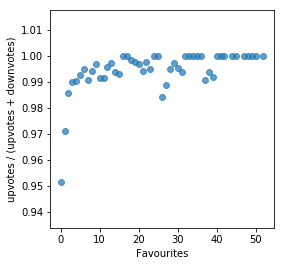

In [59]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

data = np.array([ [el[0], el[1]] for el in top_50 ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.7)
plt.xlabel('Favourites')
plt.ylabel('upvotes / (upvotes + downvotes)')
plt.show()

# Q3  (answer_percentage)   

In [34]:
import numbers

def Get_Ustr_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:    
            UsrId = int(root.get('Id'))
            Reputation = int(root.get('Reputation'))
            return (UsrId, Reputation)
        
        except:
            return None
        
    else:
        return None
    
def Get_Posts_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            
            if 'OwnerUserId' in root.attrib:
                UsrId = int(root.attrib['OwnerUserId'])
            else:
                UsrId = -2
            
            quest, answ = 0, 0
            
            var = int(root.get('PostTypeId')) 
            if var == 1: quest += 1
            elif var == 2: answ += 1
            
            return (UsrId, (quest, answ))
        except:
            return None
    else:
        return None
    
def Filter(el):
    try:
        key, val = el
        if isinstance(key, numbers.Number) and isinstance(val[1], numbers.Number) and isinstance(val[0][0], numbers.Number) and isinstance(val[0][1], numbers.Number):
            return True
        else:
            False
    except:
        return False

In [42]:
my_input_Posts = r'spark-stats-data\allPosts\part-0*'
my_input_Users = r'spark-stats-data\allUsers\part-0*'

posts = sc.textFile(my_input_Posts).map(Get_Posts_Info).filter(lambda x: x is not None)
users = sc.textFile(my_input_Users).map(Get_Ustr_Info).filter(lambda x: x is not None)

In [52]:
table = posts.join(users).filter(Filter)\
        .map(lambda k_v: (k_v[0], (k_v[1][1], k_v[1][0][0], k_v[1][0][1])) )\
        .reduceByKey(lambda x,y: (x[0], x[1]+y[1], x[2]+y[2]) )\
        .filter(lambda k_v: k_v[1][1]+k_v[1][2]!=0 )\
        .map(lambda k_v: (k_v[1][0], k_v[1][2]/float(k_v[1][1]+k_v[1][2])) )\
        .sortByKey(ascending=False)\
        .take(99)
table

[(100976, 0.996694214876033),
 (92624, 0.9959749552772809),
 (47334, 0.9803049555273189),
 (46907, 0.9918793503480279),
 (32283, 0.9817351598173516),
 (27599, 1.0),
 (25406, 0.9909747292418772),
 (23610, 0.847870182555781),
 (23102, 0.9875647668393782),
 (22706, 0.968421052631579),
 (20315, 0.9794871794871794),
 (20133, 0.9728813559322034),
 (19312, 0.9833333333333333),
 (18866, 0.9543147208121827),
 (17719, 1.0),
 (16854, 0.9872773536895675),
 (16131, 0.956081081081081),
 (14768, 0.9659442724458205),
 (14500, 1.0),
 (14100, 0.9772151898734177),
 (13557, 0.9970059880239521),
 (13078, 1.0),
 (12491, 0.9724137931034482),
 (12098, 0.9411764705882353),
 (11989, 0.846441947565543),
 (11865, 1.0),
 (11830, 0.8158844765342961),
 (11795, 0.9823008849557522),
 (11662, 0.9912280701754386),
 (11083, 0.9930313588850174),
 (10750, 0.9700854700854701),
 (10728, 0.9850427350427351),
 (10552, 0.8206896551724138),
 (10394, 0.9757575757575757),
 (10383, 0.9857142857142858),
 (10045, 0.9107142857142857),

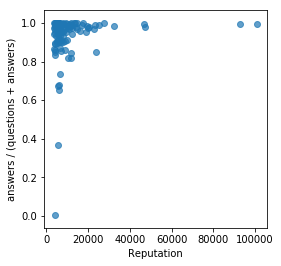

In [57]:
data = np.array([ [el[0], el[1]] for el in table ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.7)
plt.xlabel('Reputation')
plt.ylabel('answers / (questions + answers)')
plt.show()

Average answer percentage

In [63]:
avg_ = posts.map(lambda k_v: (1, (k_v[1][0], k_v[1][1])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )\
        .map(lambda k_v: (k_v[1][0], k_v[1][1], k_v[1][1]/float(k_v[1][0]+k_v[1][1])) )\
        .collect()
        
print('tot. Q = {0},\t\t tot. A = {1}, \t avg answer percentage = {2}'.format(avg_[0][0], avg_[0][1], avg_[0][2])  )

tot. Q = 52046,		 tot. A = 55298, 	 avg answer percentage = 0.5151475629751081


# Q4 (post_counts)

In [80]:
def parse_Posts_trf_3(line):    
    
    root = applyParser(line)
    
    if root is not None:
        try:
        
            if 'OwnerUserId' in root.attrib:
                OwnerUserId = int(root.attrib['OwnerUserId'])
            else:
                OwnerUserId = -2
                
            return (OwnerUserId, 1)
        
        except:
            return None
        
    else:
        return None
    

    
def parse_User_Record_trf_1(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            Id, Reputation = int(root.attrib['Id']), int(root.attrib['Reputation'])
            return (Id, Reputation)
            
        except:
            return None
            
    else:
        return None

In [88]:
my_input_dir = r'spark-stats-data\allPosts\part-0*'

Own_Id_vs_QA = sc.textFile(my_input_dir)\
    .map(parse_Posts_trf_3)\
    .filter(lambda x: x is not None)\
    .reduceByKey(lambda va, vb: va+vb)
    
my_input_dir = r'spark-stats-data\allUsers\part-0*'

Usr_Id_vs_Rep = sc.textFile(my_input_dir)\
    .map(parse_User_Record_trf_1)\
    .filter(lambda x: x is not None)

# qa____RepSum_Counts = (qa, (rep_sum, counts))
# UsrId___rep_qa = (UsrId, (rep, qa))
# QA____AvgRep = (QA, AvgRep)

Usr_Id_vs_Rep_vs_QA = Usr_Id_vs_Rep.join(Own_Id_vs_QA)\
    .map(lambda UsrId___rep_qa: (UsrId___rep_qa[1][1], (UsrId___rep_qa[1][0],1)) )\
    .reduceByKey(lambda va, vb: (va[0]+vb[0], va[1]+vb[1]))\
    .map(lambda qa____RepSum_Counts:  (qa____RepSum_Counts[0], float(qa____RepSum_Counts[1][0]/qa____RepSum_Counts[1][1])) )\
    .sortBy(lambda QA____AvgRep: QA____AvgRep[0], ascending=False)\
    .collect()

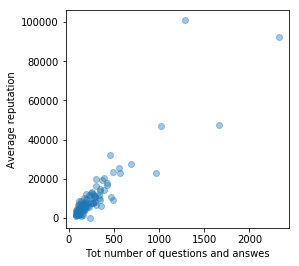

In [91]:
data = np.array([ [el[0], el[1]] for el in Usr_Id_vs_Rep_vs_QA[:100] ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.4)
plt.xlabel('Tot number of questions and answes')
plt.ylabel('Average reputation')
plt.show()